# Введение в DS на УБ и МиРА

## Семинар 13: Логистическая регрессия

#### План:
1. Логистическая регрессия
2. Ирисы Фишера. Свойства логистической регрессии
3. Логистическая регрессия на менее приятных данных.
4. ROC-кривая. 
5. Бонус: вывод логистической регрессии через правдоподобие

(адаптировано с [[источник](https://github.com/hse-ds/iad-intro-ds/tree/master/2022/seminars/sem09_logit_svm)])

---

### Логистическая регрессия (теория)

Напомним, что мы решаем задачу бинарной классификации, в которой целевая переменная $y$ принимает два значения: -1 и 1. На лекции мы обсудили, что эту задачу можно решить при помощи линейного классификатора 

$$
f(x_i, w) = \mathrm{sign}\left(\langle x_i, w \rangle\right).
$$

Функция потерь для такой задачи – это сумма индикаторов того, что предсказание сделано неверно: 

$$Q(X, w) = \frac{1}{\ell}\sum_{i = 1}^{\ell}[y_i \ne \mathrm{sign}\left(\langle x_i, w \rangle\right)].$$

Мы также обсуждали, что эту идею можно удобно записать через функцию отступа:

$$
Q(X, w) = \frac{1}{\ell}\sum_{i = 1}^{\ell}[y_i \langle x_i, w \rangle < 0].
$$

Такую функцию проблематично дифференцировать по $w$, потому что даже в местах, где градиент существует, он равен нулю. Вместо этого будем минимизировать некоторую функцию $\tilde{Q}(X, w)$, являющуюся верхней оценкой для $Q(X, w)$, и надеяться, что минимизация $\tilde{Q}(X, w)$ позволит достаточно хорошо минимизировать и $Q(X, w)$.

Логистическая регрессия предлагает использовать логистическую функцию потерь:

$$
\tilde{Q}(X, w) = \frac{1}{\ell}\sum_{i = 1}^{\ell}\log(1 + e^{-y_i \langle x_i, w \rangle}) \rightarrow \min_w.
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

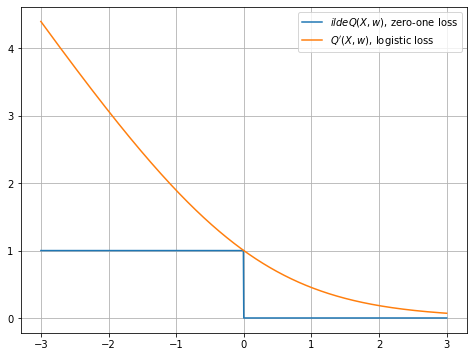

In [2]:
x = np.concatenate((np.linspace(-3, 0, 500), np.linspace(0, 3, 500))) #comcatenate берет и соединяет два массива точек. linspace генерирует точки от -3 до 0 500шт,
np.random.seed(123)
y = np.ones(1000)
w = np.ones(1000)
M = y * x * w

plt.figure(figsize = (8, 6))
plt.plot(x * w, x < 0, label = "$\tilde{Q}(X, w)$, zero-one loss")
plt.plot(M, np.log2(1 + np.exp(-M)), label = "$Q'(X, w)$, logistic loss")
plt.grid()
plt.legend();

Для получения классической задачи логистической регрессии остаётся сделать один шаг и немного изменить постановку задачи. Предположим, что мы хотим решать задачу **мягкой** классификации, то есть предсказывать не метку класса, а вероятность того, что наблюдение принадлежит к классу. Понятно, что мы всегда можем перейти от мягкой классификации к жёсткой, выбрав порог принадлежности к положительному классу. 

**Задание 1.** Поясните, почему для решения задачи мягкой классификации классификатор $f(x_i, w) = \left(\langle x_i, w \rangle\right)$ – не лучший выбор. 

**Ответ:**

Полученное скалярное произведение необязательно будет лежать в отрезке $[0, 1]$.

Мы можем решить названную проблему, подставив $\left(\langle x_i, w \rangle\right)$ в некоторую функцию, областью значений которой является промежуток от 0 до 1. В логистической регрессии такой функцией выступает **сигмоида**:

$$
\sigma(x) = \dfrac{e^x}{1 + e^x} = \dfrac{1}{1 + e^{-x}}.
$$

**Задание 2.** Сигмоида обаладет замечательнеым свойством, которое значительно упрощает вычисление градиентов при градиентном спуске:

$$
\sigma(x)'_x = \sigma(x)(1 - \sigma(x)). 
$$

Покажите, что это действительно так.

**Решение:**

$$
\sigma(x)' = \frac{e^x(1 + e^x) - e^{2x}}{(1 + e^x)^2} = \frac{e^x}{1 + e^x}\frac{1}{1 + e^x} = \sigma(x)(1-\sigma(x)).
$$

Путём хитрых математических преобразований, описанных ниже, можно показать, что при использовании сигмоиды (= при решении задачи мягкой классификации) $\tilde{Q}(X, w)$ можно записать в следующем виде:

$$
\tilde{Q}(X, w) = -\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\sigma(\langle x_i, w \rangle) + [y_i = -1]\log(1-\sigma(\langle x_i, w \rangle)
$$

Эта функция называется log-loss или кросс-энтропией между истинной целевой переменной и предсказанными вероятностями.

**А почему? А потому:**

$$
\tilde{Q}(X, w) = -\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\sigma(\langle x_i, w \rangle) + [y_i = -1]\log(1-\sigma(\langle x_i, w \rangle) =\\
$$
$$
=-\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\left(\frac{1}{1 + e^{-\langle x_i, w\rangle}}\right) + [y_i = -1](\log\left(1-\frac{1}{1 + e^{-\langle x_i, w\rangle}}\right)) =\\
$$
$$
=-\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\left(\frac{1}{1 + e^{-\langle x_i, w\rangle}}\right) + [y_i = -1](\log\left(\frac{1}{1 + e^{\langle x_i, w\rangle}}\right)) =\\
$$
$$
=\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log(1 + e^{-\langle x_i, w \rangle}) + [y_i = -1]\log(1 + e^{\langle x_i, w \rangle}) =\\
$$
$$
=\frac{1}{\ell} \sum_{i=1}^{\ell}\log(1 + e^{-y_i\langle x_i, w\rangle}) = \tilde{Q}(X, w)
$$

### Саммари по логистической регрессии


- Данные: $y_i \in \{-1, 1\}$, $X$

- Предсказания:

    - По умолчанию предсказывает вероятности:
    $$
    \hat{p}_i = \sigma(\langle x_i, w\rangle) = \frac{1}{1 + e^{-\langle x_i, w\rangle}}
    $$
    
    - Если хотим перейти к метке, то сравниваем вероятность с порогом $t$:
    
    $$
    \hat{y}_i = \begin{cases}
    1,&\text{ если } \hat{p}_i > t,\\
    -1,&\text{ иначе.}
    \end{cases}
    $$
    
- Обучение: 

$$
\tilde{Q}(X, w) = -\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\sigma(\langle x_i, w \rangle) + [y_i = -1]\log(1-\sigma(\langle x_i, w \rangle) \to \min_w
$$

### Ирисы Фишера. Тестируем логистическую регрессию

Рассмотрим свойства логистической регрессии и метода опорных векторов на примере классического набора данных ["Ирисы Фишера"](https://ru.wikipedia.org/wiki/Ирисы_Фишера). Этот набор состоит из 150 наблюдений, каждое из которых представляет собой четыре измерения: длина наружной доли околоцветника (`sepal length`), ширина наружной доли околоцветника (`sepal width`), длина внутренней доли околоцветника (`petal length`), ширина внутренней доли околоцветника (`petal width`). Каждое наблюдение относится к одному из трёх классов ириса: `setosa`, `versicolor` или `virginica`. Задача состоит в том, чтобы по измерениям предсказать класс цветка. 

[<img src="https://miro.medium.com/max/1000/1*Hh53mOF4Xy4eORjLilKOwA.png" alt="drawing" width="800"/>](https://miro.medium.com/max/1000/1*Hh53mOF4Xy4eORjLilKOwA.png)

In [3]:
from sklearn.datasets import load_iris
data = load_iris()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


**Задание 1.** Перейдём к задаче бинарной классификации: будем предсказывать принадлежность цветка к виду `versicolor` против принадлежности ко всем прочим видам. Перекодируйте зависимую переменную так, чтобы цветки вида `versicolor` имели метку 1, а прочих видов – метку -1. 

In [6]:
# Перекодировка
y_new = []
for i in range(len(y)):
    if y[i] != 1:
        y_new.append(-1)
    else:
        y_new.append(1)

In [7]:
y_new = np.array(y_new)

In [8]:
y_new

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

**Задание 2**. Будем работать с двумя признаками: `sepal length (cm)` и `sepal width (cm)`. Отделите их в отдельную матрицу. Разделите выборку на обучающую и тестовую, долю тестовой выборки укажите равной 0.3. Отмасштабируйте выборки при помощи StandardScaler. Постройте диаграмму рассеяния по тренировочной выборке и убедитесь, что данные линейно не разделимы. 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
np.random.seed(123)

X = X[['sepal length (cm)', 'sepal width (cm)']]

X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size = 0.3, random_state = 201905, stratify = y_new)


In [20]:
cnt_train = 0
for i in range(len(y_train)):
    if y_train[i] == 1:
        cnt_train = cnt_train + 1

In [22]:
cnt_test = 0
for i in range(len(y_test)):
    if y_test[i] == 1:
        cnt_test = cnt_test+ 1

In [23]:
cnt_train/len(y_train) #обучающая выборка

0.3333333333333333

In [25]:
cnt_test/len(y_test) #тестовая выборка

0.3333333333333333

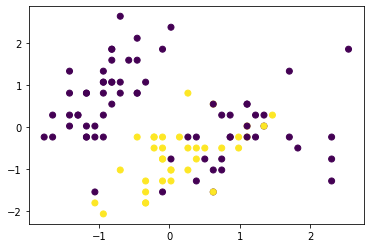

In [27]:
# Отмасштабируйте признаки
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train)

**Задание 3.** Обучите логистическую регрессию на тренировочной выборке. Убедитесь, что `accuracy`, возможно, не подходит в качестве метрики для данной задачи и рассчитайте `f1-меру` на тестовой выборке.

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
lr = LogisticRegression()

# Обучите логистическую регрессию 
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

p_pred_prob = lr.predict_proba(X_test)

In [30]:
y_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [31]:
p_pred_prob

array([[3.61756501e-04, 9.99638243e-01],
       [4.24039173e-06, 9.99995760e-01],
       [1.01505374e-03, 9.98984946e-01],
       [7.34083260e-07, 9.99999266e-01],
       [1.73157038e-04, 9.99826843e-01],
       [7.97957880e-02, 9.20204212e-01],
       [7.93428971e-07, 9.99999207e-01],
       [1.06780495e-05, 9.99989322e-01],
       [1.26884687e-04, 9.99873115e-01],
       [2.02232702e-03, 9.97977673e-01],
       [2.05395145e-03, 9.97946049e-01],
       [4.74225041e-08, 9.99999953e-01],
       [4.66221789e-05, 9.99953378e-01],
       [1.37141064e-04, 9.99862859e-01],
       [9.57689100e-06, 9.99990423e-01],
       [5.88674910e-05, 9.99941133e-01],
       [5.53180497e-05, 9.99944682e-01],
       [2.33777222e-05, 9.99976622e-01],
       [4.59705162e-08, 9.99999954e-01],
       [1.30891841e-04, 9.99869108e-01],
       [4.24039173e-06, 9.99995760e-01],
       [1.10486812e-07, 9.99999890e-01],
       [4.74225041e-08, 9.99999953e-01],
       [3.14121157e-05, 9.99968588e-01],
       [9.435477

первая - жесткая, вторая - мягкая

Теперь посмотрим, как различаются решающие поверхности алгоритмов. 

Код ниже построит решающую поверхность для классификатора. Чтобы он заработал, нужно обязательно сделать `fit` для `lr` выше.

In [34]:
from sklearn.metrics import f1_score

In [35]:
f1_score(y_test, y_pred)

0.5172413793103449

In [38]:
! pip install mlxtend

# В Колабе, возможно
# !pip install mlxtend --upgrade

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


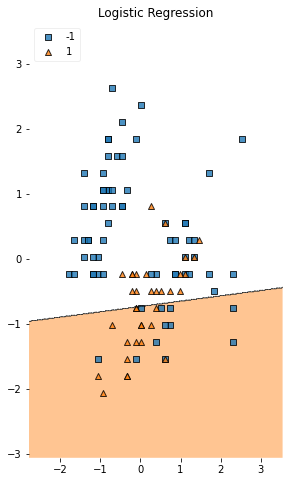

In [39]:
import itertools

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_decision_regions

gs = gridspec.GridSpec(1, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression']
for clf, lab, grd in zip([lr],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = np.array(X_train), y = np.array(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Задание 4.** Теперь посмотрим на решение задачи мягкой классификации. При помощи метода `predict_proba()` любой из обученных логистических регрессий сделайте предсказание вероятностей положительного класса.

In [42]:
p_pred_prob = lr.predict_proba(X_test)

In [43]:
p_pred_prob

array([[3.61756501e-04, 9.99638243e-01],
       [4.24039173e-06, 9.99995760e-01],
       [1.01505374e-03, 9.98984946e-01],
       [7.34083260e-07, 9.99999266e-01],
       [1.73157038e-04, 9.99826843e-01],
       [7.97957880e-02, 9.20204212e-01],
       [7.93428971e-07, 9.99999207e-01],
       [1.06780495e-05, 9.99989322e-01],
       [1.26884687e-04, 9.99873115e-01],
       [2.02232702e-03, 9.97977673e-01],
       [2.05395145e-03, 9.97946049e-01],
       [4.74225041e-08, 9.99999953e-01],
       [4.66221789e-05, 9.99953378e-01],
       [1.37141064e-04, 9.99862859e-01],
       [9.57689100e-06, 9.99990423e-01],
       [5.88674910e-05, 9.99941133e-01],
       [5.53180497e-05, 9.99944682e-01],
       [2.33777222e-05, 9.99976622e-01],
       [4.59705162e-08, 9.99999954e-01],
       [1.30891841e-04, 9.99869108e-01],
       [4.24039173e-06, 9.99995760e-01],
       [1.10486812e-07, 9.99999890e-01],
       [4.74225041e-08, 9.99999953e-01],
       [3.14121157e-05, 9.99968588e-01],
       [9.435477

In [47]:
np.sum(p_pred_prob, axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Логистическая регрессия на менее приятных данных

Мы будем работать с [набором данных](https://www.kaggle.com/piyushgoyal443/red-wine-dataset?select=wineQualityReds.csv), содержащим информацию о характеристиках вина. Каждое наблюдение принадлежит к одному из 10 категорий качества вина, и наша задача заключается в том, что предсказать эту категорию. 

In [50]:
data = pd.read_csv('wineQualityReds.csv', index_col = 0)
data.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Как указано в описании набора, в нём нет пропущенных значений, и все переменные являются непрерывными. Целевая переменная – `quality`. 

**Задание 1.** Перейдём к задаче бинарной классификации и будем предсказывать только наиболее популярную категорию качества. Закодируйте столбец `quality` так, чтобы наиболее частая категория (это категория 5) получила метку 1, а все прочие категории – метку -1.

**Задание 2.** Разделите признаки и целевую переменную. Разделите выборку на тренировочную и тестовую, долю тестовой выборки укажите равной 0.3. При помощи `StandardScaler` отмасштабируйте тренировочную и тестовую выборки. 

In [448]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**Задание 3.** Обучите логистическую регрессию. Убедитесь, что доля правильных ответов – не лучший вариант для нашей задачи и рассчитайте F-меру на тестовой выборке. 

**Задание 4.** Проинтерпретируйте коэффициенты оценённой модели.

**Задание 5.** Попробуйте поменять какие-либо гиперпараметры, чтобы добиться более высокого качества на тестовой выборке. 

### ROC-кривая

Ранее мы узнали, что помимо accuracy в задачах классификации так же используются precision, recall и f-мера. Теперь пришло время познакомиться с ещё одной метрикой – ROC AUC.

Для начала вспомним, что мы работаем с матрицей ошибок:

|       | alg = 1          | alg = -1    |
|-------| -----------------|-------------|
|y = 1  |TP                |FN           |
|y = -1 |FP                | TN          |

Определим следующие величины:

$$
TPR \text{ (true positive rate, recall, sensitivity)} = \dfrac{TP}{TP + FN}
$$
– доля правильно предсказанных объектов положительного класса.

$$
FPR \text{ (false positive rate, 1 - specificity)} = \dfrac{FP}{FP + TN}
$$
– доля неправильно предсказанных объектов отрицательного класса.

Рассмотрим задачу мягкой классификации: мы предказываем вероятности принадлежности наблюдения к положительному и отрицательному классам. Тогда TPR и FPR будут зависеть от порога для вероятности, выше которого наблюдение будет отнесено к положительному классу. ROC-кривая строится в координатах $(FPR, TPR)$ и показывает комбинации TPR и FPR при всевозможных значениях порога. 

Для хорошего классификатора эта кривая является вогнутой, а для идеального классификатора она будет проходить через точку $(0, 1)$ (почему?).

[<img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png" alt="drawing" width="350"/>](https://ru.wikipedia.org/wiki/ROC-кривая)



**Задание 1.** Постройте ROC-кривую для следующей выборки.

In [56]:
# True labels
y = [-1, 1, 1, -1, 1, 1]
# Predicted labels
p = [0.5, 0.1, 0.2, 0.9, 0.7, 0.1]

**Решение:**
1. Упорядочим наблюдения по **убыванию** ответов алгоритма.

In [51]:
y = [-1, 1, -1, 1, 1, 1]
p = [0.9, 0.7, 0.5, 0.2, 0.1, 0.1]

2. Разобьём единичный квадрат на $(m, n)$ частей, где $m$ – число 1 в $y$, $n$ – число нулей. Стартуем из точки $(0, 0)$. Если значение $y$ равно 1, делаем шаг вверх, а если -1 – вправо. Понятно, что конечная точка нашего маршрута – точка $(1, 1)$.

**Важный момент:** если у нескольких объектов значения предсказаний равны, а $y$ – различны, то мы должны сделать ход "по диагонали". 

Если построить кривую по этому алгоритму, то получим:

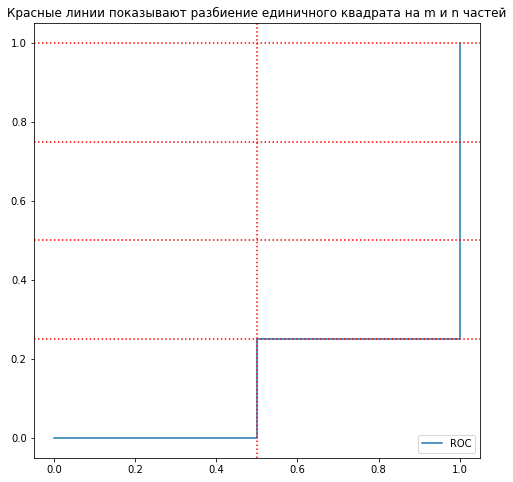

In [65]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y, p)

plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, label = 'ROC')
plt.axvline(0.5, linestyle = 'dotted', c = 'red')
plt.axhline(0.25, linestyle = 'dotted', c = 'red')
plt.axhline(0.5, linestyle = 'dotted', c = 'red')
plt.axhline(0.75, linestyle = 'dotted', c = 'red')
plt.axhline(1.0, linestyle = 'dotted', c = 'red')
plt.title('Красные линии показывают разбиение единичного квадрата на m и n частей')
plt.legend()

3. Полученная кривая и является ROC-кривой. 

**(Почему этот алгоритм имеет смысл?)**

**Пример с диагональным шагом.**

In [66]:
p = [0.5, 0.1, 0.2, 0.6, 0.2, 0.3, 0.0]
y = [-1,  -1,   -1, 1,    1,   1,   -1]

In [67]:
fpr, tpr, _ = roc_curve(y, p)

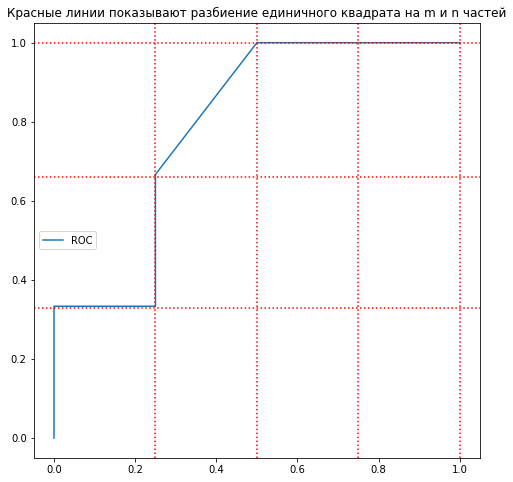

In [68]:
plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, label = 'ROC')
plt.axvline(0.25, linestyle = 'dotted', c = 'red')
plt.axvline(0.5, linestyle = 'dotted', c = 'red')
plt.axvline(0.75, linestyle = 'dotted', c = 'red')
plt.axvline(1.0, linestyle = 'dotted', c = 'red')
plt.axhline(0.33, linestyle = 'dotted', c = 'red')
plt.axhline(0.66, linestyle = 'dotted', c = 'red')
plt.axhline(1.0, linestyle = 'dotted', c = 'red')
plt.title('Красные линии показывают разбиение единичного квадрата на m и n частей')
plt.legend()

**Задание 2.** ROC AUC – площадь под ROC-кривой – равна доле пар наблюдений $(y = 1, y = -1)$, которые алгоритм верно упорядочил. Таким образом, чем больше ROC AUC, тем качественнее отработал классификатор. Вычислите ROC AUC для построенной ROC-кривой из первого примера. 

**Решение:**

In [52]:
0.25 * 0.5

0.125

**Задание 3.** Как выглядит ROC-кривая для случайного классификатора? 


**Задание 4.** Как по ROC-кривой выбрать порог для бинаризации?

В `sklearn` реализовано вычисление значений ROC-кривой и площади под ней. 

In [54]:
from sklearn.metrics import roc_curve, auc

**Важно:** в `roc_curve` передаются предсказанные вероятности!

**Задание 5.** Постройте ROC-кривую и рассчитайте площадь под ней для логистической регрессии на данных о вине. О чём говорит такая форма кривой?

In [462]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

# ...

### Бонус для самых смелых: вывод логистической регрессии через правдоподобие

Перекодируем $y$ так, что её возможные значения – это 0 и 1. Теперь $y$ является случайной величиной из распределения Бернулли. Тогда сигмоида задаёт условную вероятность принадлежности $y$ к положительному классу:

$$
P(y_i = 1 | x_i, w) = \sigma(x_i, w).
$$

Будем искать оценку коэффициентов $w$ при помощи метода максимального правдоподобия.

$$
\mathcal{L} = \sigma(x_i, w)^{\sum_i y_i}(1 - \sigma(x_i, w))^{\sum_i 1 - y_i}
$$

Логарифмируем:

$$
\mathcal{l} = \sum_i y_i \log\sigma(x_i, w) + (1 - y_i)(1 - \log\sigma(x_i, w))
$$

Если теперь взять среднее, то мы получим log-loss, взятый со знаком минус. Таким образом, минимизация функции потерь в логистической регрессии эквивалентна  максимизации правдоподобия в задаче нахождения оценок $w$!